# Extract Frames from Videos
Extract frames from test videos using random sampling

In [2]:
import cv2
import glob
import pandas as pd
import numpy as np
import os

from pathlib import Path

n_samples = 100
data_dir = Path('/repos/gs/rat-emotion/videos/24fps')
test_videos = glob.glob(str(data_dir / 'rat[8-9]*.mp4'))
output_dir = Path('/repos/temp/dlc-validators/set1')

# Create output dir if it does not exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Create (file, frame) pairs 
test_data = pd.DataFrame(columns=['file', 'frame'])
for video in test_videos:
    cap = cv2.VideoCapture(video)
    frames = np.arange(0, cap.get(cv2.CAP_PROP_FRAME_COUNT)).astype(int)
    video_data = pd.DataFrame(data=frames, columns=['frame'])
    video_data['file'] = video
    test_data = pd.concat([test_data, video_data], axis=0)
    cap.release()
    
# Random sample the (file, frame) pairs
sample_indices = np.random.choice(np.arange(test_data.shape[0]), size=n_samples)
samples = test_data.iloc[sample_indices]

# For sample in samples, extract frames to output folder
for idx, sample in samples.iterrows():
    file = sample['file']
    frame = sample['frame']
    
    cap = cv2.VideoCapture(file)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
    ret, img = cap.read()
    
    filename = os.path.split(file)[1] # Seperate the filename from the folder
    filename = os.path.splitext(filename)[0] # Seperate the extension from the filename
    
    output_file = str(output_dir / f"{filename}_{frame}.png")
    cv2.imwrite(output_file, img)
    
print(f"Saved images to folder:\n {output_dir}")

Saved images to folder:
 /repos/temp/dlc-validators/set1


# Compare 

In [146]:
import re
import math

scaling_factor = 2
test_data_path = "/repos/true.h5"
labeled_data_dir = Path('/repos/gs/rat-emotion/dlc/analyzed-videos/2020-07-25_DLC_resnet50_MousePoseJul21shuffle1_1030000')

output = []
df = pd.read_hdf(test_data_path)
idx = pd.IndexSlice
count = 0

# Group by video
grouped = df.groupby(lambda x: re.match('.*(rat\d-(control|lps)\d).*', x).groups()[0])

# Iterate over videos
for name, group in grouped:
    # Get the video's datafile 
    predicted_file = glob.glob(str(labeled_data_dir / name) + '*.h5')[0]
    predicted = pd.read_hdf(predicted_file)
    
    # Iterate over rows
    for row_index, row in group.iterrows():
        # Extract the frame index from the row index (row index is the image filename)
        frame_idx = re.match('.*_(\d+)\.png', row_index).groups()[0]
        frame_idx = int(frame_idx)
        
        # Iterate over bodyparts
        bodyparts = row.index.get_level_values(1).unique()
        s = pd.Series(index=pd.MultiIndex.from_product([bodyparts, ('dr', 'likelihood')]), dtype=float, name=count)
        for bodypart in bodyparts:
            # Get the true x, y values
            true_x = row.loc[idx[:, bodypart, 'x']].values[0] 
            true_y = row.loc[idx[:, bodypart, 'y']].values[0]
            
            # Get the predicted x, y, and likelihood values
            predicted_x = predicted.loc[frame_idx, idx[:, bodypart, 'x']].values[0] * scaling_factor
            predicted_y = predicted.loc[frame_idx, idx[:, bodypart, 'y']].values[0] * scaling_factor
            likelihood = predicted.loc[frame_idx, idx[:, bodypart, 'likelihood']].values[0]
            
            # Find the deltas
            dx = abs(true_x - predicted_x)
            dy = abs(true_y - predicted_y)
            dr = math.sqrt(dx**2 + dy**2)
            
            # Save to output
            s[(bodypart,'dr')] = dr
            s[(bodypart,'likelihood')] = likelihood
            
        count += 1
        output.append(s)
    
output = pd.DataFrame(output)

# Graph Results

In [142]:
! ffprobe /repos/gs/rat-emotion/videos/24fps/rat1-control1.mp4

ffprobe version 3.4.8-0ubuntu0.2 Copyright (c) 2007-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

## Plot distances

Text(0.5, 1.0, 'Pixel Distance Between True and Predicted Poses')

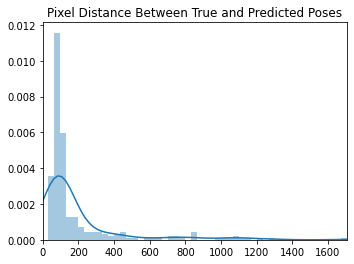

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns

# output.mean()
deltas = output.loc[:, idx[:, 'dr']]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
g = sns.distplot(deltas)
g.set(xlim=(0, deltas.max().max()))
plt.title("Pixel Distance Between True and Predicted Poses")
# for index, column in enumerate(deltas.columns):
#     plt.hist()

## Plot Distances per Body Part

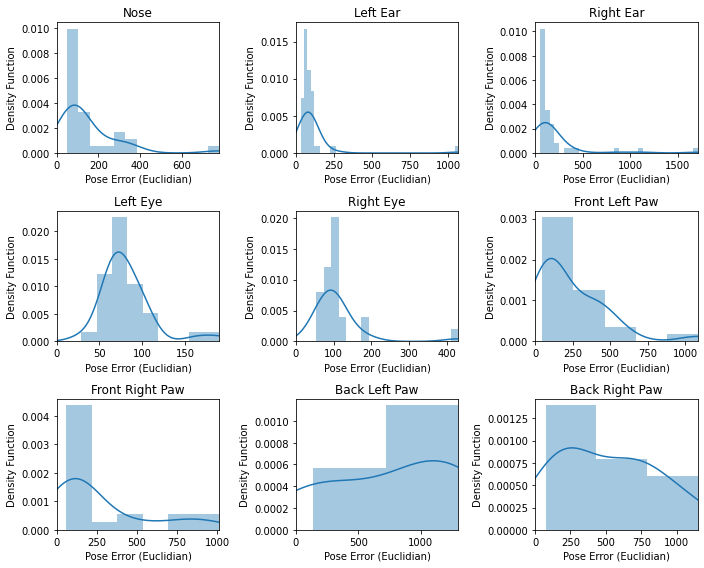

In [190]:
import matplotlib.pyplot as plt
import seaborn as sns

max_distance = (2704**2 + 1520**2)**(1/2)

# output.mean()
plt.figure(figsize=(10, 8))
plt.tight_layout()
plt.subplots_adjust(hspace = .4)
for index, bodypart in enumerate(bodyparts):
    deltas = output.loc[:, idx[bodypart, 'dr']]
    deltas = deltas.dropna(axis=0)
    plt.subplot(3, 3, index+1)
    plt.tight_layout()
    g = sns.distplot(deltas, kde=True)
    g.set(xlim=(0, deltas.max()))
    plt.title(bodypart.replace('_', ' ').title())
    plt.xlabel("Pose Error (Euclidian)")
    plt.ylabel("Density Function")
    
plt.savefig('pose-error.png')

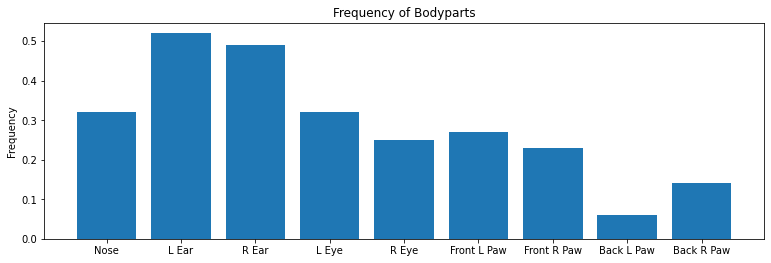

In [204]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,3))
ax = fig.add_axes([0,0,1,1])
ax.bar([bodypart.replace('_', ' ').replace('left', 'L').replace('right', 'R').title() for bodypart in bodyparts], output.loc[:,idx[:,'dr']].count() / 100)
plt.title('Frequency of Bodyparts')
plt.ylabel('Frequency')
plt.savefig('bodypart-freq.png')